# Binance full history analysis using Spark

Import necessary PySpark library SparkSession to read the data

In [1]:
from pyspark.sql import SparkSession

In order to work with Hadoop and Hive in the background it is necessary to initialize a spark session and give a name to the new app.

We are able to set the metastore uri and warehouse directory spark will use as data source.

It is necessary to enable hive support.

In [ ]:
spark = SparkSession.builder.appName('BinanceFullHistory').config('spark.hadoop.hive.metastore.uris', 'thrift://localhost:9083').config('spark.hadoop.hive.metastore.warehouse.dir', '/user/hive/warehouse').enableHiveSupport().getOrCreate()

It is possible to validate the settings of the SparkSession by calling the object spark.

It also displays a link to the Spark UI application, where we can actually monitor all the background reading activities of the engine and its performance.

In [3]:
spark

Using a PySpark Data Frame object we can store the file content in a readable format.

To retrieve the data we use the method ```spark.read.parquet```.

We added to the data frame 2 columns, one containing the name of the file from witch the row was extracted from and another with the crypto-pair identified from the file name itself so we can filter the data frame by pair.

In [4]:
from pyspark.sql.functions import input_file_name
from pyspark.sql.functions import substring


df_binance = spark.read.parquet('/binance-full-history/*.parquet')
df_binance = df_binance.withColumn('filename', input_file_name())
df_binance = df_binance.withColumn('pair', substring('filename', 44, 9))

We also explored the capability of using pandas library to manipulate the data, by extracting a limited amount of lines from the data source and converting it into a pandas data frame.

In [5]:
df = df_binance.limit(10000).toPandas()

/home/hdoop/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [6]:
#df.drop(['pair', 'open_time', 'close'], 1, inplace=True)
df.head()

open         high          low        close    volume  \
0  4261.479980  4261.479980  4261.479980  4261.479980  1.775183   
1  4261.479980  4261.479980  4261.479980  4261.479980  0.000000   
2  4280.560059  4280.560059  4280.560059  4280.560059  0.261074   
3  4261.479980  4261.479980  4261.479980  4261.479980  0.012008   
4  4261.479980  4261.479980  4261.479980  4261.479980  0.140796   

   quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
0         7564.906738                 3                     0.075183   
1            0.000000                 0                     0.000000   
2         1117.542969                 2                     0.261074   
3           51.171852                 3                     0.012008   
4          599.999329                 1                     0.140796   

   taker_buy_quote_asset_volume           open_time  \
0                    320.390839 2017-08-17 05:00:00   
1                      0.000000 2017-08-17 05:01:00   
2                   1117.542969 2017-08-17 05:02:00   
3                     51.171852 2017-08-17 05:03:00   
4                    599.999329 2017-08-17 05:04:00   

                                            filename       pair  
0  hdfs://localhost:9000/binance-full-history/BTC...  BTC-USDT_  
1  hdfs://localhost:9000/binance-full-history/BTC...  BTC-USDT_  
2  hdfs://localhost:9000/binance-full-history/BTC...  BTC-USDT_  
3  hdfs://localhost:9000/binance-full-history/BTC...  BTC-USDT_  
4  hdfs://localhost:9000/binance-full-history/BTC...  BTC-USDT_

In [7]:
df.describe()

open          high           low         close        volume  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean    4111.415039   4114.186523   4109.518066   4112.195801      0.558313   
std      156.453064    155.781967    157.197174    156.682190      0.973810   
min     3400.000000   3400.000000   3400.000000   3400.000000      0.000000   
25%     4026.817566   4027.370117   4025.000000   4027.000000      0.000000   
50%     4100.000000   4101.660156   4100.000000   4101.339844      0.182009   
75%     4203.662354   4208.770020   4198.310181   4204.969971      0.662336   
max     4485.390137   4485.390137   4485.390137   4485.390137     13.137162   

       quote_asset_volume  number_of_trades  taker_buy_base_asset_volume  \
count        10000.000000      10000.000000                 10000.000000   
mean          2305.236084          3.286900                     0.354491   
std           4058.719482          5.593918                     0.815526   
min              0.000000          0.000000                     0.000000   
25%              0.000000          0.000000                     0.000000   
50%            751.048706          2.000000                     0.007053   
75%           2724.914856          4.000000                     0.320068   
max          55924.445312        150.000000                    10.959697   

       taker_buy_quote_asset_volume  
count                  10000.000000  
mean                    1472.701172  
std                     3416.352051  
min                        0.000000  
25%                        0.000000  
50%                       28.965505  
75%                     1323.592560  
max                    48622.511719

We imported the library matplotlib to plot a few graphs in order to display information in a way that is more easily understandable. In the code below we are printing the avg closing price of Binance's 1000 more traded crypto products, as well as thhe moving averadge of their price over the days.

In [10]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

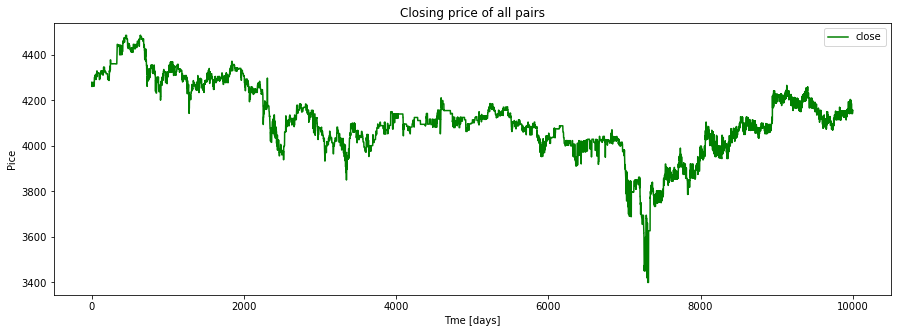

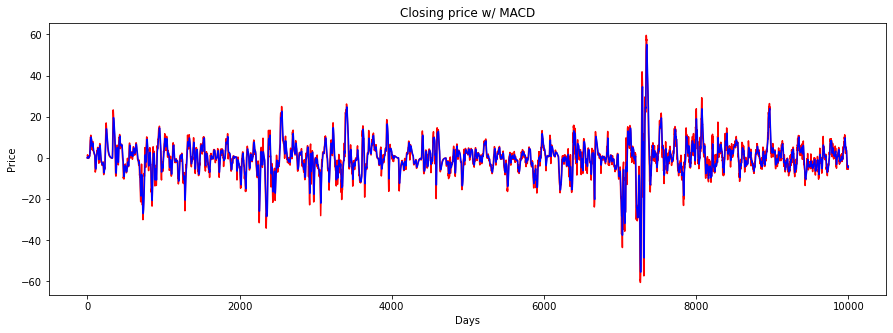

In [13]:
df.set_index('open_time')

short_ema = df.close.ewm(span = 12, adjust = False).mean()
long_ema = df.close.ewm(span = 26, adjust = False).mean()

macd = short_ema - long_ema
signal = macd.ewm(span = 9, adjust = False).mean()

# Closing prince over the time
plt.figure(figsize=(15,5))
#plt.plot(df.open.values, color = 'red', label = 'open')
plt.plot(df.close.values, color = 'green', label = 'close')
#plt.plot(df.low.values, color = 'blue', label = 'low')
#plt.plot(df.high.values, color = 'black', label = 'high')
plt.title('Closing price of all pairs')
plt.xlabel('Tme [days]')
plt.ylabel('Pice')
plt.legend(loc = 'best')
plt.show()

# MACD over the time
plt.figure(figsize = (15, 5))
plt.plot(df.index, macd, label = 'Binance MACD', color = 'red')
plt.plot(df.index, signal, label = 'Signal line', color = 'blue')
plt.title("Closing price w/ MACD")
plt.xlabel('Days')
plt.ylabel('Price')
plt.show()

From PySpark data frame is also possible to analyse the data and display it directly to a graph using the same matplotlib library, and we demonstrated that by building a figure of the closing price vs open time of all traded products, limited by ten thousand.

We also printed the top ten biggest closing prices to understand which products are Binance's top performances, which can be observed below. *Due to limited processing capacity we could not run this same analysis over the full history, so we used a ten thousand record sample from the original spark data frame.*

In [14]:
y_close = [val.close for val in df_binance.limit(10000).select('close').collect()]

In [15]:
x_open_time = [val.open_time for val in df_binance.limit(10000).select('open_time').collect()]

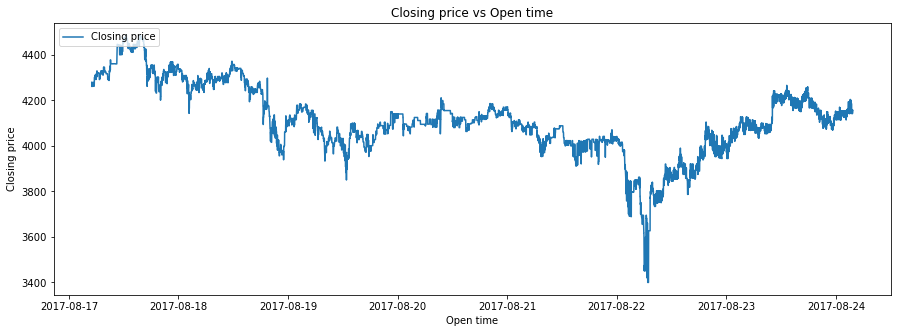

In [16]:
plt.figure(figsize = (15, 5))
plt.plot(x_open_time, y_close)
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()

In [17]:
df_binance_top_10 = df_binance.groupBy("pair").mean("close").limit(10000)

In [35]:
df_binance_top_10.orderBy('avg(close)', ascending = False).limit(10).show()

+---------+--------------------+
|     pair|          avg(close)|
+---------+--------------------+
|BTC-BIDR_| 3.128620695424473E9|
|ETH-BIDR_|2.9395495729641214E7|
|BNB-BIDR_|2.5440420827115096E7|
|BTC-NGN_c|1.6343238075966317E7|
|BNB-IDRT_|   6425848.032944444|
|DOT-BIDR_|  4407257.8191159265|
|BTC-RUB_c|   2121622.544422753|
|SOL-BIDR_|   1388534.967414757|
|BTC-UAH_c|   993757.9665936495|
|BTC-TRY_c|   317350.0234143417|
+---------+--------------------+



In conclusion to the analysis we have plotted two graphs displaying the performance of their most popular products which are the pairs ETH-BTC and BTC-USDT. We created two pyspark data frames from the hive warehouse and defined the vertical series of the lines graph as the closing price and the horizontal series as the open time of the pair trade in Binance platform.

It is possible to observe the behaviour of Ethereum (ETH) compared to Bitcoin (BTC) from 2018 up to 2023 as well as the behaviour of Bitcoin (BTC) compared to Thether dollar (USDT), which is collaterized in US dollar, which brings a perspective of how Bitcoin behave compared to US dollar (USDT) for the same period.

In [20]:
df_ethbtc = spark.read.parquet('/binance-full-history/ETH-BTC_copy_1.parquet')

In [25]:
y_close = [val.close for val in df_ethbtc.select('close').collect()]

In [26]:
x_open_time = [val.open_time for val in df_ethbtc.select('open_time').collect()]

In [31]:
df_btceth = spark.read.parquet('/binance-full-history/BTC-USDT_copy_1.parquet')

y_close_b = [val.close for val in df_btceth.select('close').collect()]
x_open_time_b = [val.open_time for val in df_btceth.select('open_time').collect()]

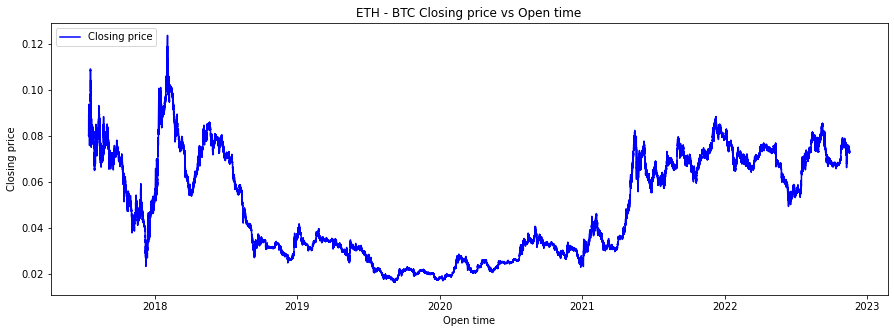

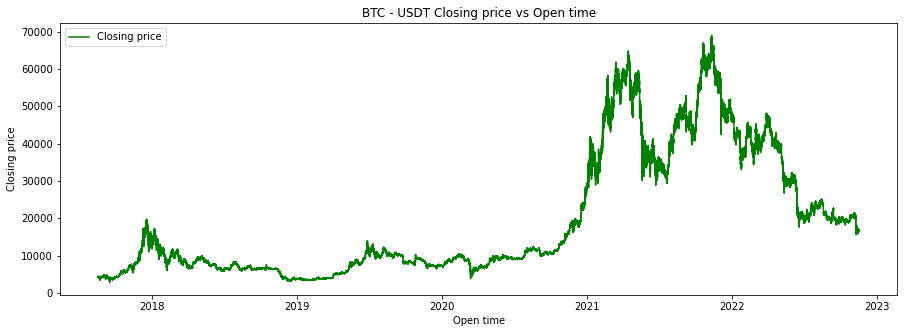

In [34]:
plt.figure(figsize = (15, 5))
plt.plot(x_open_time, y_close, color = 'blue', label = 'ETH')
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('ETH - BTC Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()

plt.figure(figsize = (15, 5))
plt.plot(x_open_time_b, y_close_b, color = 'green', label = 'ETH')
plt.ylabel('Closing price')
plt.xlabel('Open time')
plt.title('BTC - USDT Closing price vs Open time')
plt.legend(['Closing price'], loc = 'upper left')
plt.show()

This analysis used the data provided by J.J.H. SMIT obtained from the website https://kaggle.com.

### References

Smit, J.J.H. (2022) https://www.kaggle.com/datasets/jorijnsmit/binance-full-history, Kaggle. Available at: https://www.kaggle.com (Accessed: March, 20, 2023).